In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

In [6]:
new_deaths_df = pd.read_csv('new_deaths', index_col='Date')

In [7]:
new_deaths_df

,NO2,CO,PM25,OZONE,PM10,NO,new_deaths
Date,,,,,,,
2020-01-26,0.020,0.4930,47.3,0.040,50.5,0.005,0.0
2020-01-27,0.042,0.8220,24.6,0.041,40.8,0.071,0.0
2020-01-28,0.042,0.7370,14.9,0.042,27.8,0.083,0.0
2020-01-29,0.031,0.7320,11.0,0.042,44.7,0.037,0.0
2020-01-30,0.043,1.0460,16.2,0.038,42.0,0.094,0.0
...,...,...,...,...,...,...,...
2020-10-14,0.040,1.0230,22.4,0.060,47.0,0.049,19.0
2020-10-15,0.057,0.7690,22.9,0.059,48.8,0.054,22.0
2020-10-16,0.041,0.7105,21.4,0.050,50.9,0.034,22.0


In [43]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=16
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(new_deaths_df, variables = new_deaths_df.columns)   

,NO2_x,CO_x,PM25_x,OZONE_x,PM10_x,NO_x,new_deaths_x
NO2_y,1.0000,0.0000,0.0202,0.0124,0.0088,0.0080,0.0002
CO_y,0.0001,1.0000,0.0975,0.1317,0.0016,0.0007,0.1425
PM25_y,0.0101,0.0000,1.0000,0.1070,0.0000,0.0555,0.1371
OZONE_y,0.0037,0.0014,0.0113,1.0000,0.0173,0.1114,0.0002
PM10_y,0.0889,0.0012,0.0000,0.0123,1.0000,0.0593,0.0253
NO_y,0.0001,0.0000,0.0360,0.0123,0.0761,1.0000,0.0002
new_deaths_y,0.0000,0.0004,0.0044,0.0762,0.0005,0.0000,1.0000


In [9]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(new_deaths_df)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
NO2    ::  175.25    > 111.7797  =>   True
CO     ::  118.27    > 83.9383   =>   True
PM25   ::  77.66     > 60.0627   =>   True
OZONE  ::  47.31     > 40.1749   =>   True
PM10   ::  23.05     > 24.2761   =>   False
NO     ::  5.15      > 12.3212   =>   False
new_deaths ::  0.09      > 4.1296    =>   False


In [11]:
nobs = int(len(new_deaths_df) * .15)
df_train, df_test = new_deaths_df[0:-nobs], new_deaths_df[-nobs:]

# Check size
print(df_train.shape)  # (119, 8)
print(df_test.shape)  # (4, 8)

(227, 7)
(40, 7)


In [12]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")    

In [13]:
for name, column in df_train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "NO2" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.8678
 No. Lags Chosen       = 14
 Critical value 1%     = -3.462
 Critical value 5%     = -2.875
 Critical value 10%    = -2.574
 => P-Value = 0.0492. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "CO" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -3.8845
 No. Lags Chosen       = 12
 Critical value 1%     = -3.461
 Critical value 5%     = -2.875
 Critical value 10%    = -2.574
 => P-Value = 0.0022. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "PM25" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 

In [14]:
df_differenced = df_train.diff().dropna()

In [15]:
# ADF Test on each column of 1st Differences Dataframe
for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "NO2" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -7.105
 No. Lags Chosen       = 13
 Critical value 1%     = -3.462
 Critical value 5%     = -2.875
 Critical value 10%    = -2.574
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "CO" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -6.8849
 No. Lags Chosen       = 11
 Critical value 1%     = -3.461
 Critical value 5%     = -2.875
 Critical value 10%    = -2.574
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "PM25" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 T

In [16]:
model = VAR(df_differenced)
for i in range(1,22):
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  -20.071522027788085
BIC :  -19.22129259435054
FPE :  1.919286939836583e-09
HQIC:  -19.72836593786244 

Lag Order = 2
AIC :  -20.428898012033073
BIC :  -18.829688925226023
FPE :  1.3441648955012456e-09
HQIC:  -19.783379286203296 

Lag Order = 3
AIC :  -20.61166264356806
BIC :  -18.258727877626992
FPE :  1.1231198481697278e-09
HQIC:  -19.66179868437942 

Lag Order = 4
AIC :  -20.95818798520086
BIC :  -17.846730739614944
FPE :  7.989861036898229e-10
HQIC:  -19.70197526126125 

Lag Order = 5
AIC :  -21.517576375011856
BIC :  -17.642748317172607
FPE :  4.612515580381956e-10
HQIC:  -19.952990120583436 

Lag Order = 6
AIC :  -21.70305633341337
BIC :  -17.059956826813092
FPE :  3.8902018953080163e-10
HQIC:  -19.828050242623263 

Lag Order = 7
AIC :  -21.76158946795021
BIC :  -16.34526478559507
FPE :  3.7494272042347705e-10
HQIC:  -19.574095383506585 

Lag Order = 8
AIC :  -21.807845165137167
BIC :  -15.613287687830532
FPE :  3.6877718274306506e-10
HQIC:  -19.30577276143444

/opt/miniconda3/envs/tensorflow/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


In [64]:
model_fitted = model.fit(maxlags=16, ic='aic')
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 27, Oct, 2020
Time:                     14:41:09
--------------------------------------------------------------------
No. of Equations:         7.00000    BIC:                   -16.3453
Nobs:                     219.000    HQIC:                  -19.5741
Log likelihood:           557.661    FPE:                3.74943e-10
AIC:                     -21.7616    Det(Omega_mle):     8.88808e-11
--------------------------------------------------------------------
Results for equation NO2
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                -0.000134         0.000461           -0.290           0.772
L1.NO2               -0.381741         0.173646           -2.198           0.028
L1.CO                 0.006623         0.007469            0.8

In [65]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)
def adjust(val, length= 6): return str(val).ljust(length)
for col, val in zip(new_deaths_df.columns, out):
    print(adjust(col), ':', round(val, 2))

NO2    : 2.11
CO     : 1.97
PM25   : 2.02
OZONE  : 2.1
PM10   : 1.99
NO     : 2.1
new_deaths : 1.93


In [66]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  #> 4

# Input data for forecasting
forecast_input = df_differenced.values[-lag_order:]
forecast_input

7


array([[ 6.00e-03,  8.10e-02, -8.00e-01,  0.00e+00,  3.30e+00,  1.10e-02,
         1.20e+01],
       [-5.00e-03,  1.38e-01,  8.70e+00,  7.00e-03,  1.25e+01, -1.50e-02,
        -1.20e+01],
       [ 5.00e-03,  2.05e-01,  3.10e+00,  1.20e-02,  9.10e+00,  1.00e-03,
         1.00e+00],
       [ 2.00e-03,  1.70e-01,  1.90e+00,  1.20e-02, -1.30e+00,  0.00e+00,
        -2.80e+01],
       [-1.10e-02, -1.40e-01, -2.90e+00, -7.00e-03, -1.38e+01, -7.00e-03,
        -1.40e+01],
       [-6.00e-03, -2.29e-01,  4.91e+01, -2.40e-02,  2.20e+00, -6.00e-03,
         2.00e+01],
       [-1.00e-03, -1.90e-01, -2.81e+01,  0.00e+00, -4.00e-01, -1.00e-03,
        -1.90e+01]])

In [67]:
# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=new_deaths_df.index[-nobs:], columns=new_deaths_df.columns + '_1d')
df_forecast

,NO2_1d,CO_1d,PM25_1d,OZONE_1d,PM10_1d,NO_1d,new_deaths_1d
Date,,,,,,,
2020-09-09,0.002367,-0.022534,-11.916183,0.001065,2.560543,-0.009030,46.624776
2020-09-10,-0.004157,-0.011899,-10.641605,0.004335,-17.331738,0.006008,-1.683010
2020-09-11,0.006225,0.167780,-13.146349,0.001029,-11.236814,0.013677,-9.710893
2020-09-12,0.005046,0.194185,27.413254,-0.001478,20.994953,0.012645,-24.111386
2020-09-13,0.004489,0.025933,2.430947,0.002292,18.197846,-0.002755,17.886103
2020-09-14,-0.007778,-0.105996,7.267285,-0.000394,-3.780137,-0.013403,-20.377767
2020-09-15,0.001074,-0.104662,-5.799461,0.001404,-8.478925,0.000220,-0.946003
2020-09-16,-0.002610,-0.050970,-1.645187,0.000931,-2.229631,-0.006049,25.217916
2020-09-17,-0.002208,0.019077,-7.797446,-0.000015,-2.813505,-0.000108,6.669753


In [68]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

In [69]:
df_results = invert_transformation(df_train, df_forecast, second_diff=False)        
# df_results.loc[:, ['rgnp_forecast', 'pgnp_forecast', 'ulc_forecast', 'gdfco_forecast',
#                    'gdf_forecast', 'gdfim_forecast', 'gdfcf_forecast', 'gdfce_forecast']]
df_results

,NO2_1d,CO_1d,PM25_1d,OZONE_1d,PM10_1d,NO_1d,new_deaths_1d,NO2_forecast,CO_forecast,PM25_forecast,OZONE_forecast,PM10_forecast,NO_forecast,new_deaths_forecast
Date,,,,,,,,,,,,,,
2020-09-09,0.002367,-0.022534,-11.916183,0.001065,2.560543,-0.009030,46.624776,0.015367,0.296466,33.983817,0.049065,41.860543,-0.007030,52.624776
2020-09-10,-0.004157,-0.011899,-10.641605,0.004335,-17.331738,0.006008,-1.683010,0.011209,0.284567,23.342213,0.053400,24.528805,-0.001022,50.941766
2020-09-11,0.006225,0.167780,-13.146349,0.001029,-11.236814,0.013677,-9.710893,0.017434,0.452347,10.195864,0.054430,13.291991,0.012655,41.230874
2020-09-12,0.005046,0.194185,27.413254,-0.001478,20.994953,0.012645,-24.111386,0.022481,0.646532,37.609118,0.052951,34.286944,0.025300,17.119488
2020-09-13,0.004489,0.025933,2.430947,0.002292,18.197846,-0.002755,17.886103,0.026970,0.672465,40.040064,0.055244,52.484790,0.022545,35.005590
2020-09-14,-0.007778,-0.105996,7.267285,-0.000394,-3.780137,-0.013403,-20.377767,0.019192,0.566469,47.307349,0.054850,48.704653,0.009142,14.627823
2020-09-15,0.001074,-0.104662,-5.799461,0.001404,-8.478925,0.000220,-0.946003,0.020266,0.461807,41.507888,0.056254,40.225728,0.009362,13.681820
2020-09-16,-0.002610,-0.050970,-1.645187,0.000931,-2.229631,-0.006049,25.217916,0.017656,0.410837,39.862700,0.057185,37.996097,0.003313,38.899736
2020-09-17,-0.002208,0.019077,-7.797446,-0.000015,-2.813505,-0.000108,6.669753,0.015448,0.429915,32.065254,0.057170,35.182592,0.003206,45.569490


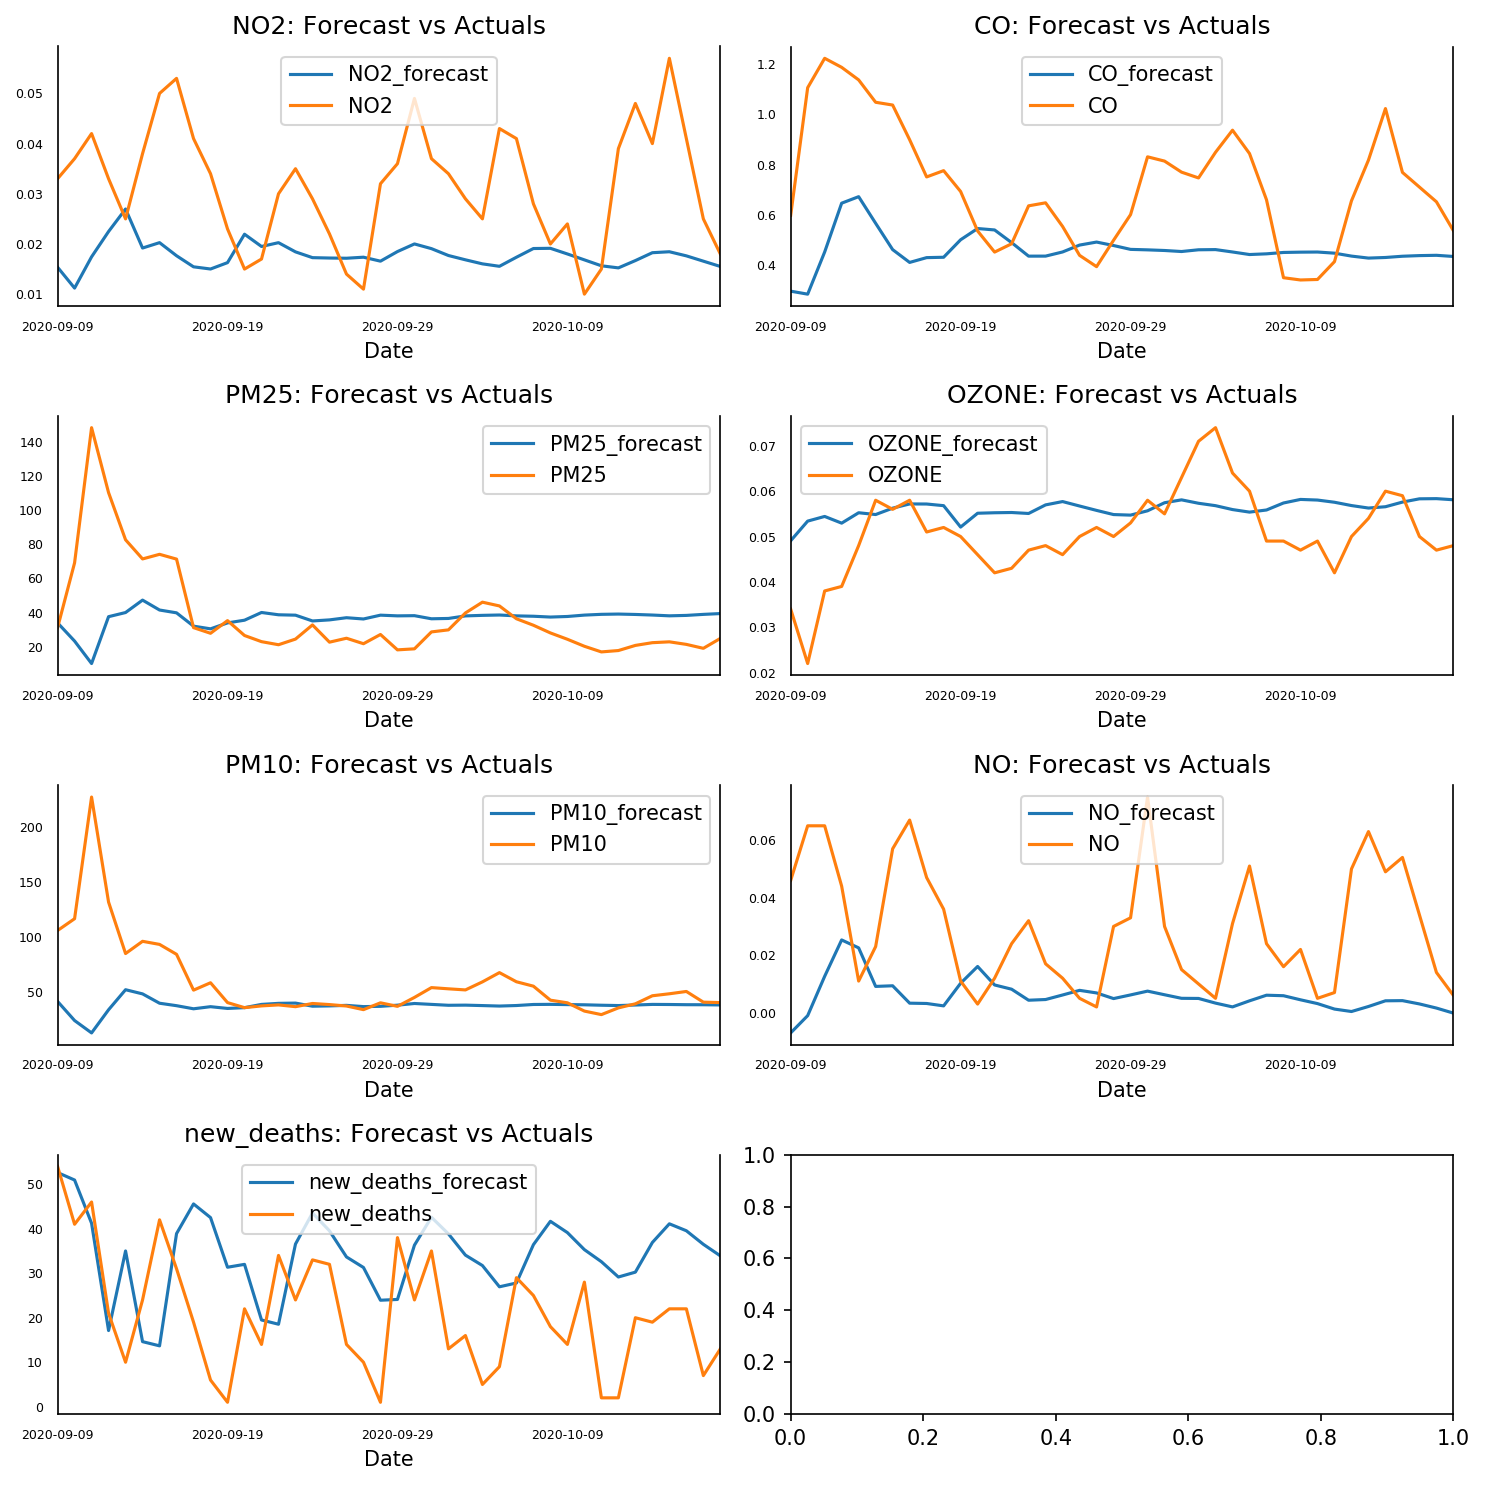

In [70]:
fig, axes = plt.subplots(nrows=int(len(new_deaths_df.columns)/2) + 1, ncols=2, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(new_deaths_df.columns, axes.flatten())):
    df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    df_test[col][-nobs:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [71]:
from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})

print('Forecast Accuracy of: NO2')
accuracy_prod = forecast_accuracy(df_results['NO2_forecast'].values, df_test['NO2'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('\nForecast Accuracy of: CO')
accuracy_prod = forecast_accuracy(df_results['CO_forecast'].values, df_test['CO'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('\nForecast Accuracy of: PM25')
accuracy_prod = forecast_accuracy(df_results['PM25_forecast'].values, df_test['PM25'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('\nForecast Accuracy of: OZONE')
accuracy_prod = forecast_accuracy(df_results['OZONE_forecast'].values, df_test['OZONE'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('\nForecast Accuracy of: PM10')
accuracy_prod = forecast_accuracy(df_results['PM10_forecast'].values, df_test['PM10'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('\nForecast Accuracy of: NO')
accuracy_prod = forecast_accuracy(df_results['NO_forecast'].values, df_test['NO'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('\nForecast Accuracy of: new_deaths')
accuracy_prod = forecast_accuracy(df_results['new_deaths_forecast'].values, df_test['new_deaths'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

Forecast Accuracy of: NO2
mape   :  0.4415
me     :  -0.014
mae    :  0.0155
mpe    :  -0.3305
rmse   :  0.0185
corr   :  -0.0358
minmax :  0.4239

Forecast Accuracy of: CO
mape   :  0.3574
me     :  -0.258
mae    :  0.2877
mpe    :  -0.2786
rmse   :  0.351
corr   :  0.1456
minmax :  0.3495

Forecast Accuracy of: PM25
mape   :  0.5252
me     :  -1.0145
mae    :  19.1414
mpe    :  0.3075
rmse   :  30.2676
corr   :  -0.4752
minmax :  0.3471

Forecast Accuracy of: OZONE
mape   :  0.1915
me     :  0.0053
mae    :  0.0082
mpe    :  0.1468
rmse   :  0.0102
corr   :  0.437
minmax :  0.1442

Forecast Accuracy of: PM10
mape   :  0.2538
me     :  -21.325
mae    :  22.6646
mpe    :  -0.2138
rmse   :  44.8488
corr   :  -0.5484
minmax :  0.2511

Forecast Accuracy of: NO
mape   :  0.8933
me     :  -0.0242
mae    :  0.0258
mpe    :  -0.4734
rmse   :  0.033
corr   :  -0.1354
minmax :  0.7431

Forecast Accuracy of: new_deaths
mape   :  3.107
me     :  12.9228
mae    :  16.8359
mpe    :  2.995
rmse   : 